In [21]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [22]:
asset_type = "all"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = f"median"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [25]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
train_df = train_df[~train_df[metric_pct_chg].isna()].reset_index(drop=True)

eval_df = df[df["year"] >= eval_start_year]
eval_df = eval_df[~eval_df[metric_pct_chg].isna()].reset_index(drop=True)

# Finally
df = df.fillna(0)

print(f"Train: {train_df.shape}, Eval: {eval_df.shape}")
# Try only for building. Try training separately for building. 

Train: (32582, 55), Eval: (5377, 55)


<Axes: ylabel='Frequency'>

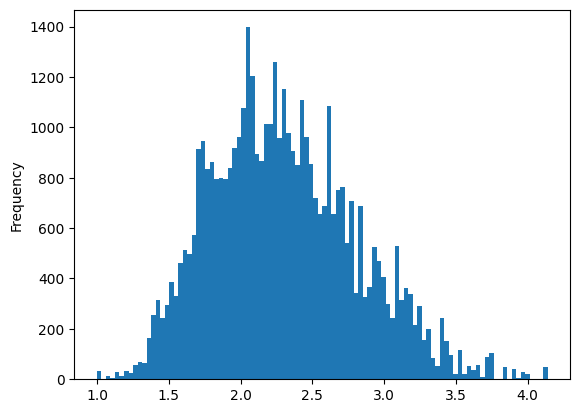

In [26]:
df["weight"].plot.hist(bins = 100)

In [27]:
train_df[(train_df["area_code"] == 13101) & (train_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
4,2007,2.271493e+06,0.393871,0.983720
282,2008,2.333333e+06,0.105263,0.022257
1036,2009,1.920000e+06,-0.154741,-0.316067
3919,2010,2.037037e+06,-0.126984,-0.215148
5501,2011,1.444444e+06,-0.247685,-0.672931
9296,2012,1.455556e+06,-0.285455,-0.658649
11072,2013,2.303030e+06,0.594406,1.149448
13836,2014,2.000000e+06,0.374046,0.689789
16238,2015,2.173913e+06,-0.056064,-0.243456
19832,2016,2.645833e+06,0.322917,0.263091


In [28]:
eval_df[(eval_df["area_code"] == 13101) & (eval_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
669,2021,4.420875e+06,0.312098,0.326362
3044,2022,4.333333e+06,0.143981,0.108697


In [29]:
idx = 3044
row = eval_df.iloc[idx]
target = row[normalized_metric_pct_chg]
area_code, asset_type, year = row["area_code"], row["asset_type"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["asset_type"] == asset_type)
        & (df["year"] <= year - years_ahead)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window["time_diff"] = year - window["year"]
window

Target: 0.1086970580159127


,area_code,area,year,asset_type,unit_price_median_pct_chg,count_growth,yearly_price_growth,total_tax_growth,taxable_income_growth,taxable_income_per_taxpayer_growth,net_migration_ratio,new_dwellings_ratio,taxpayer_count_growth,unit_price_median,count,total_traded_area,in_migrations,out_migrations,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,total_tax,new_dwellings,existing_dwellings,unit_price_median_log_normalized_yearly,count_log_normalized_yearly,total_traded_area_log_normalized_yearly,in_migrations_log_normalized_yearly,out_migrations_log_normalized_yearly,population_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log_normalized_yearly,new_dwellings_log_normalized_yearly,existing_dwellings_log_normalized_yearly,unit_price_median_pct_chg_normalized_yearly,count_growth_normalized_yearly,yearly_price_growth_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,new_dwellings_ratio_normalized_yearly,taxpayer_count_growth_normalized_yearly,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,metric_pct_chg_is_available,condo,land,log_population,weight,time_diff
25354,13101,Tokyo-to Chiyoda-ku,2016,building,0.322917,0.094340,0.217083,0.057706,0.123044,0.079495,0.014473,0.039881,0.040342,2.645833e+06,58.0,9205.0,6383.0,5502.0,60870.0,34324.0,314359478.0,9158.591015,18441614.0,1545.0,38740.0,3.730712,0.289411,-0.250691,1.216502,1.114543,0.523614,0.802649,1.482009,7.603764,1.141374,0.845219,-0.074495,0.263091,0.149500,0.238921,1.701550,2.655749,2.312005,2.098075,3.512231,1.393531,1,1,1,1,1,0.0,0.0,4.784410,2.336942,6
27578,13101,Tokyo-to Chiyoda-ku,2017,building,0.811250,-0.172414,0.488189,0.034839,0.061411,0.031304,0.017522,0.035125,0.029192,3.937500e+06,48.0,7930.0,6764.0,5682.0,61751.0,35326.0,333664476.0,9445.294571,19084096.0,1415.0,40285.0,3.965719,0.130143,-0.400546,1.249490,1.135597,0.534038,0.813907,1.505415,7.715785,1.155406,0.790261,-0.047802,1.139829,-0.602418,0.787178,0.874264,0.993094,0.614242,2.438227,3.318686,0.892909,1,1,1,1,1,0.0,0.0,4.790651,2.339479,5
32089,13101,Tokyo-to Chiyoda-ku,2018,building,0.156985,0.041667,-0.222555,0.038361,0.086993,0.057856,0.032212,0.023453,0.027543,3.061189e+06,50.0,8190.0,7493.0,5469.0,62833.0,36299.0,362690825.0,9991.758037,19816187.0,978.0,41700.0,3.752636,0.173999,-0.353986,1.311832,1.111261,0.546386,0.825697,1.542575,7.940593,1.169816,0.498544,-0.024595,0.145502,-0.000859,-0.180940,1.209655,1.393402,1.052541,4.400478,1.380043,1.097581,1,1,1,1,1,0.0,0.0,4.798195,2.346408,4
33739,13101,Tokyo-to Chiyoda-ku,2019,building,-0.144300,-0.040000,0.100657,0.092478,0.138419,0.082474,0.028108,0.018523,0.051682,3.369318e+06,48.0,8015.0,7436.0,5613.0,64857.0,38175.0,412894018.0,10815.822344,21648748.0,787.0,42487.0,3.769223,0.157702,-0.346326,1.308803,1.127406,0.567887,0.852648,1.606913,8.332152,1.144342,0.382544,-0.018104,-0.318289,-0.191292,0.008706,2.177431,2.858103,1.872620,3.782471,1.054255,2.663746,1,1,1,1,1,0.0,0.0,4.811964,2.360177,3
36128,13101,Tokyo-to Chiyoda-ku,2020,building,0.237409,-0.375000,0.124246,-0.049652,-0.028845,-0.070201,0.014607,0.026555,0.044479,3.787942e+06,30.0,3550.0,6727.0,5753.0,66680.0,39873.0,400984266.0,10056.536152,20573851.0,1159.0,43646.0,3.793781,-0.318818,-1.235481,1.252633,1.153447,0.586892,0.877719,1.584503,8.057172,1.130354,0.760177,-0.001492,0.186068,-1.292728,-0.030154,-0.959826,-0.743067,-1.852744,2.062858,3.075325,2.542786,1,1,1,1,1,0.0,0.0,4.824002,2.372984,2


In [8]:
log_normalize_columns = [
    metric,
    "count",
    "total_traded_area",
    "in_migrations",
    "out_migrations",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    "yearly_price_growth",
    "count_growth",
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
    "metric_pct_chg_is_available",
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
    + (["condo", "land"] if asset_type == "all" else [])
)

final_columns = id_columns + feature_columns

In [9]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 27) (1,) [1.68264233] [2.90101942]
1 (1, 27) (1,) [-0.22611018] [3.96037426]
2 (1, 27) (1,) [0.98371965] [2.26179947]
3 (1, 27) (1,) [0.72838827] [2.30635921]
0 torch.Size([5, 27]) torch.Size([1]) tensor([1.6826]) tensor([2.9010])
1 torch.Size([5, 27]) torch.Size([1]) tensor([-0.2261]) tensor([3.9604])
2 torch.Size([5, 27]) torch.Size([1]) tensor([0.9837]) tensor([2.2618])
3 torch.Size([5, 27]) torch.Size([1]) tensor([0.7284]) tensor([2.3064])


In [11]:
BATCH_SIZE = 256

In [12]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [13]:
len(train_dataloader)

128

# Building the Transformer Model

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [15]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [16]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 27]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 5.318689346313477


In [17]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 10

In [18]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear", # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [19]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 7.3862, Eval Loss: 6.8040
Train R^2: 0.0476, Eval R^2: 0.2615
Epoch: 1
Train Loss: 6.2344, Eval Loss: 6.2101
Train R^2: 0.1953, Eval R^2: 0.3045
Epoch: 2
Train Loss: 5.8850, Eval Loss: 6.1277
Train R^2: 0.2429, Eval R^2: 0.3062


KeyboardInterrupt: 

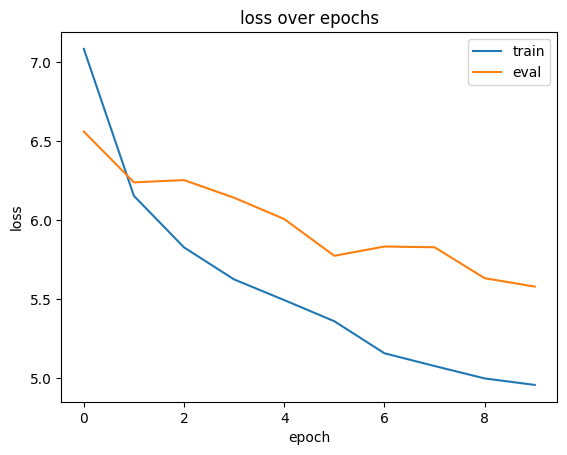

In [193]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

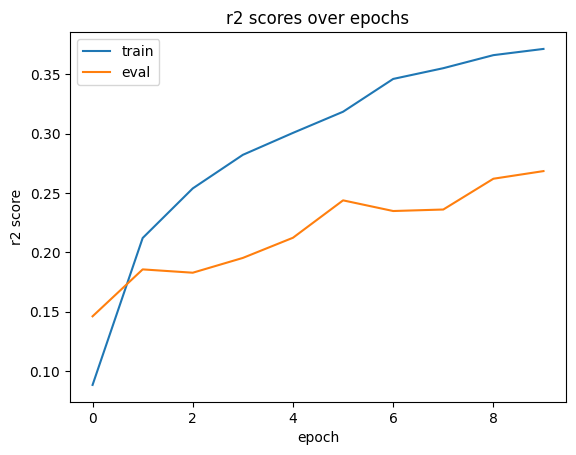

In [194]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [35]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 2.4709
Eval R2: 0.6796


In [135]:
years = [2020, 2021, 2022] # saving all predicted years.

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_returns(model, row["area_code"], row["year"], row["asset_type"]), axis=1
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
35359,2020,1610,-0.225865,-0.083333,-0.183792
35360,2020,1559,-0.126823,-0.056604,-0.163653
35361,2020,40345,0.299982,0.254167,0.212992
35362,2020,11211,-0.082083,0.255589,0.215278
35363,2020,27204,-0.095639,-0.153846,-0.236919
...,...,...,...,...,...
43476,2022,19202,-0.279620,0.291667,0.122768
43477,2022,40205,-0.291991,-0.133333,-0.361959
43478,2022,35344,-0.761920,1.200000,1.158755
43479,2022,33215,0.369334,-0.191489,-0.428288


In [38]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

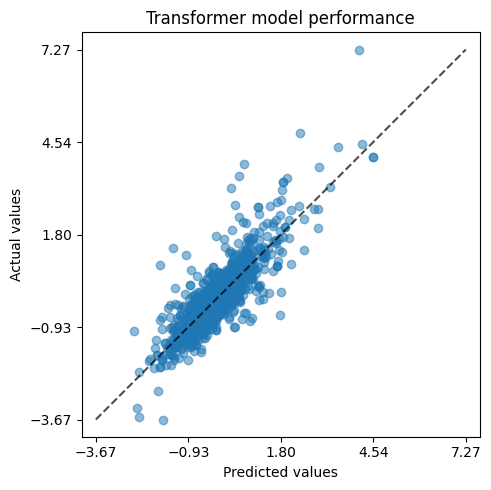

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

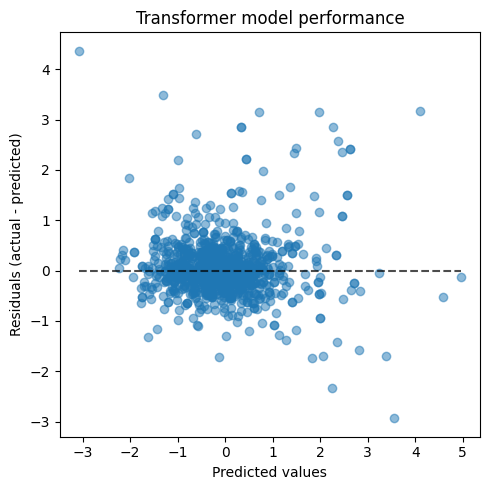

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()